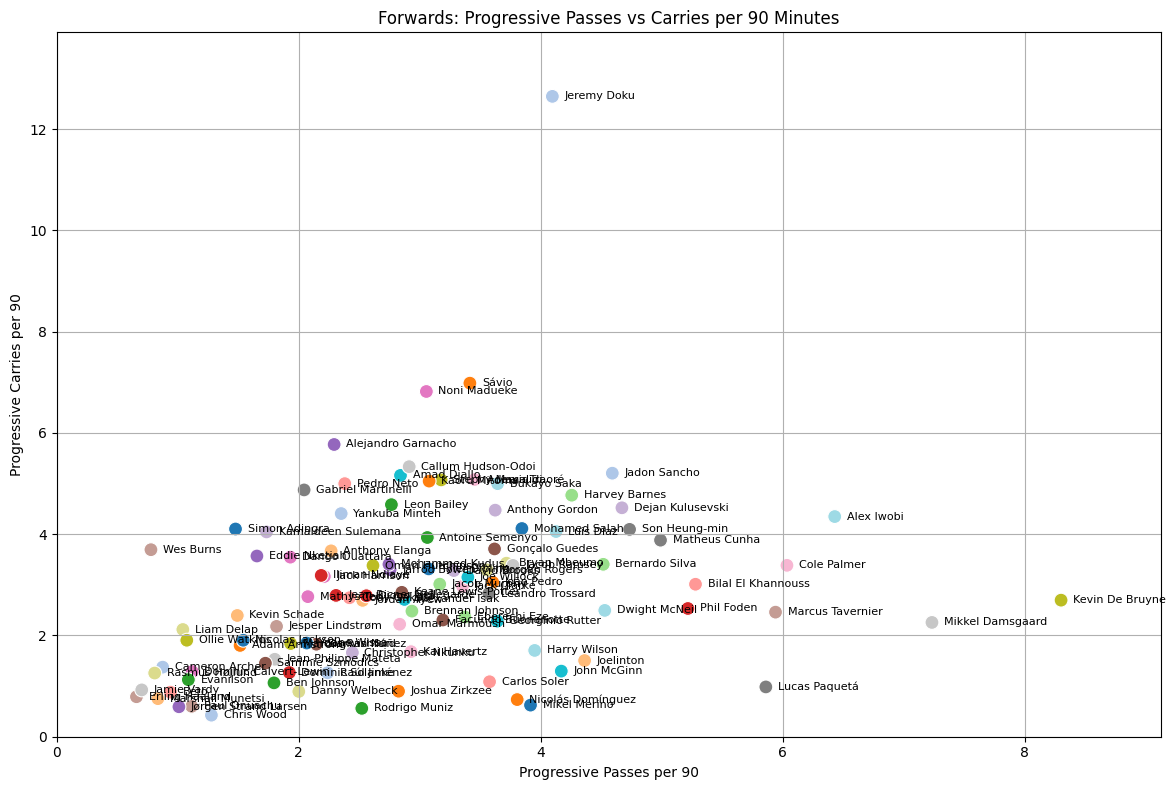

In [1]:
# Football Data: Progressive Passes vs Carries per 90 for Forwards

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env

DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME")

# Create database engine
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Define SQL query to get forwards with more than 900 minutes played
query = """
SELECT 
    "Player",
    "Pos",
    "Squad",
    "Min",
    "PrgC",
    "PrgP",
    "PrgR"
FROM player_minutes
WHERE "Pos" LIKE '%FW%' AND "Min"::integer > 900;
"""

# Read data from database into dataframe
with engine.connect() as conn:
    df = pd.read_sql(text(query), conn)

# Convert relevant columns to numeric, coercing errors to NaN
df['Min'] = pd.to_numeric(df['Min'], errors='coerce')
df['PrgC'] = pd.to_numeric(df['PrgC'], errors='coerce')
df['PrgP'] = pd.to_numeric(df['PrgP'], errors='coerce')
df['PrgR'] = pd.to_numeric(df['PrgR'], errors='coerce')

# Drop rows with missing values in important columns
df = df.dropna(subset=['Min', 'PrgC', 'PrgP', 'PrgR'])

# Calculate progressive stats per 90 minutes played
df['PrgC_per90'] = df['PrgC'] / (df['Min'] / 90)
df['PrgP_per90'] = df['PrgP'] / (df['Min'] / 90)
df['PrgR_per90'] = df['PrgR'] / (df['Min'] / 90)

# Set plot size
plt.figure(figsize=(12, 8))

# Create scatterplot with seaborn, coloring each player differently
sns.scatterplot(
    data=df,
    x='PrgP_per90',
    y='PrgC_per90',
    hue='Player',
    palette='tab20',
    s=100,
    legend=False
)

# Annotate each point with player name slightly offset
for i, row in df.iterrows():
    plt.text(row['PrgP_per90'] + 0.1, row['PrgC_per90'], row['Player'], fontsize=8, verticalalignment='center')

# Add titles and axis labels
plt.title("Forwards: Progressive Passes vs Carries per 90 Minutes")
plt.xlabel("Progressive Passes per 90")
plt.ylabel("Progressive Carries per 90")

# Set axes limits starting from zero to just above max values for padding
plt.xlim(0, df['PrgP_per90'].max() * 1.1)
plt.ylim(0, df['PrgC_per90'].max() * 1.1)

# Show grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
